In [206]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
current_palette = sns.color_palette()
import graphviz as gv
from tqdm import tqdm
pd.options.display.float_format = '{:.2f}'.format

DIR = 'C:\\Users\\User\\Notebooks_py\\Hackathon 2022\\'

In [95]:
df = pd.read_csv(f'{DIR}\\2. Новые данные\\statistics-07-20.csv', sep=';')
df.tail()

,index_train,length,car_number,destination_esr,adm,danger,gruz,loaded,operation_car,operation_date,...,operation_st_id,operation_train,receiver,rodvag,rod_train,sender,ssp_station_esr,ssp_station_id,tare_weight,weight_brutto
4189910,860009873840005.00,1.00,62827548,76404.00,NaN,NaN,161185.00,1.00,4.00,2020-07-16 03:29:00,...,2001933484.00,5.00,39513543.00,60.00,10.00,76900054.00,860009.00,2001933484.00,NaN,6256.00
4189911,860009873840005.00,1.00,62827548,76404.00,NaN,NaN,161185.00,1.00,4.00,2020-07-16 03:30:00,...,2001933484.00,5.00,39513543.00,60.00,10.00,76900054.00,860009.00,2001933484.00,NaN,6256.00
4189912,830200941862201.00,NaN,62827910,862201.00,NaN,NaN,NaN,2.00,3.00,2020-07-15 20:00:00,...,2001930776.00,4.00,NaN,60.00,10.00,NaN,862201.00,2001930776.00,NaN,1756.00
4189913,NaN,NaN,62827514,968302.00,NaN,NaN,NaN,1.00,80.00,2020-07-16 02:37:00,...,2000038612.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4189914,NaN,1.00,62827514,968302.00,20.00,NaN,161128.00,NaN,21.00,2020-07-16 04:28:00,...,2000038612.00,NaN,98098048.00,60.00,NaN,0.00,NaN,NaN,249.00,NaN


In [96]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4189915 entries, 0 to 4189914
Data columns (total 21 columns):
 #   Column            Dtype  
---  ------            -----  
 0   index_train       float64
 1   length            float64
 2   car_number        int64  
 3   destination_esr   float64
 4   adm               float64
 5   danger            float64
 6   gruz              float64
 7   loaded            float64
 8   operation_car     float64
 9   operation_date    object 
 10  operation_st_esr  float64
 11  operation_st_id   float64
 12  operation_train   float64
 13  receiver          float64
 14  rodvag            float64
 15  rod_train         float64
 16  sender            float64
 17  ssp_station_esr   float64
 18  ssp_station_id    float64
 19  tare_weight       float64
 20  weight_brutto     float64
dtypes: float64(19), int64(1), object(1)
memory usage: 671.3+ MB


index_train - Индекс поезда  
length - Длина вагона  
car_number - Номер вагона  
destination_esr - ЕСР станции назначения вагона   
adm - Код АСОУП администрации-собственника вагона  
danger - Признак опасного груза в вагоне. 1 - в вагоне опасный груз,  null - иначе  
gruz - Код груза  
loaded - Признак груженого вагона. 1 -  груженый, 2- порожний  
operation_car - Код операции ВМ АСОУП  
operation_date - Дата операции  
operation_st_esr - ЕСР станции операции  
operation_st_id - ID станции операции  
operation_train - Код операции ПМ АСОУП  
receiver - ОКПО грузополучателя  
rodvag - Род вагона АСОУП (учетного)  
rod_train - Род поезда АСОУП  
sender - ОКПО грузоотправителя  
ssp_station_esr - ЕСР станция ССП  
ssp_station_id - id станции ССП  
tare_weight - Вес тары вагона (ц)  
weight_brutto - weight_brutto  

In [97]:
# Приведем дату и время в формат timestamp
df['operation_date'] = pd.to_datetime(df.operation_date)

In [98]:
# на всякий случай сохраним данные с nan
df_nan = df[df.operation_st_esr.isnull()].copy()
# для дальнейшей работы уберем неизвестные станции
df = df[df.operation_st_esr.notnull()]
df['car_st'] = df['car_number']*1000000+df['operation_st_esr'].astype(int)
#df['car_st'] = df['car_number'].astype(str)+'-'+df['operation_st_esr'].astype(str)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4189317 entries, 0 to 4189914
Data columns (total 22 columns):
 #   Column            Dtype         
---  ------            -----         
 0   index_train       float64       
 1   length            float64       
 2   car_number        int64         
 3   destination_esr   float64       
 4   adm               float64       
 5   danger            float64       
 6   gruz              float64       
 7   loaded            float64       
 8   operation_car     float64       
 9   operation_date    datetime64[ns]
 10  operation_st_esr  float64       
 11  operation_st_id   float64       
 12  operation_train   float64       
 13  receiver          float64       
 14  rodvag            float64       
 15  rod_train         float64       
 16  sender            float64       
 17  ssp_station_esr   float64       
 18  ssp_station_id    float64       
 19  tare_weight       float64       
 20  weight_brutto     float64       
 21  car_st  

In [99]:
#удалим данные, в которых один вагон на одной станции встречается один раз, т.е. нет цепочек операций
no_chains_car_st = df.car_st.value_counts().reset_index()
no_chains_car_st = no_chains_car_st[no_chains_car_st.car_st > 1]
df = df[df.car_st.isin(no_chains_car_st['index'].values)]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3992806 entries, 0 to 4189914
Data columns (total 22 columns):
 #   Column            Dtype         
---  ------            -----         
 0   index_train       float64       
 1   length            float64       
 2   car_number        int64         
 3   destination_esr   float64       
 4   adm               float64       
 5   danger            float64       
 6   gruz              float64       
 7   loaded            float64       
 8   operation_car     float64       
 9   operation_date    datetime64[ns]
 10  operation_st_esr  float64       
 11  operation_st_id   float64       
 12  operation_train   float64       
 13  receiver          float64       
 14  rodvag            float64       
 15  rod_train         float64       
 16  sender            float64       
 17  ssp_station_esr   float64       
 18  ssp_station_id    float64       
 19  tare_weight       float64       
 20  weight_brutto     float64       
 21  car_st  

In [111]:
def get_chains(df):
    '''
    Функция вычисляет цепочки операций и продолжительность их выполнения
    chain - цепочка операций
    duration - продолжительность между текущей и предшествующей операциями
    tot_duration - продолжительность всей цепочки
    full_chain - булевая метка о том, что цепочка не промежуточная, а законченная
    предполагается, что датафрейм заранее отсортирован по id и датам
    '''   
    chains=[]
    duration=[]
    tot_duration=[]
    full_chain=[]
        
    # first node
    curr_op, next_op = df.operation_car.iloc[0:2].values
    curr_id, next_id = df.car_st.iloc[0:2].values
    chain = str(int(curr_op))
    chains.append(chain)
    dur = 0
    duration.append(dur)
    tot_dur = 0
    tot_duration.append(tot_dur)
    
    if next_id != curr_id or curr_op == -1:
        full_ch = True
    else:
        full_ch = False
    full_chain.append(full_ch)
    
    # rest nodes
    for i in tqdm(range(1, df.shape[0])):
        prev_op, curr_op = df.operation_car.iloc[i-1:i+1].values
        prev_id, curr_id = df.car_st.iloc[i-1:i+1].values

        if prev_id != curr_id or prev_op == -1:
            chain = str(int(curr_op))
            dur = 0
            tot_dur = 0
            full_ch = True
        else:
            chain += '_'+(str(int(curr_op)))
            dur = df['operation_date'].iloc[i] - df['operation_date'].iloc[i-1]
            dur = dur/np.timedelta64(1, 'h')
            tot_dur += dur
            full_ch = False

        chains.append(chain)
        duration.append(dur)
        tot_duration.append(tot_dur)
        full_chain.append(full_ch)
    
    full_chain.append(True)
    full_chain = full_chain[1:]
    
    return chains, duration, tot_duration, full_chain

In [114]:
# отсортируем данные по станции, вагону и времени операции. Пропущенные значения заменим на -1
df = df.fillna(-1).sort_values(by=['operation_st_esr','car_number','operation_date'])
df['chains'], df['duration'], df['tot_duration'], df['full_chain'] = get_chains(df)
df

100%|██████████████████████████████████████████████████████████████████████| 3992805/3992805 [08:19<00:00, 8001.07it/s]


,index_train,length,car_number,destination_esr,adm,danger,gruz,loaded,operation_car,operation_date,...,sender,ssp_station_esr,ssp_station_id,tare_weight,weight_brutto,car_st,chains,duration,tot_duration,full_chain
547697,780001251830003.00,-1.00,24286957,830003.00,-1.00,-1.00,-1.00,1.00,3.00,2020-07-19 14:49:00,...,-1.00,830003.00,2001930516.00,-1.00,6276.00,24286957830003,3,0.00,0.00,False
547703,-1.00,-1.00,24286957,830003.00,-1.00,-1.00,-1.00,1.00,80.00,2020-07-19 15:00:00,...,-1.00,-1.00,-1.00,-1.00,-1.00,24286957830003,3_80,0.18,0.18,False
788493,-1.00,1.06,24286957,830003.00,20.00,-1.00,682237.00,-1.00,28.00,2020-07-20 09:00:00,...,7776703.00,-1.00,-1.00,237.00,-1.00,24286957830003,3_80_28,18.00,18.18,False
788492,-1.00,1.06,24286957,860009.00,20.00,-1.00,421034.00,-1.00,19.00,2020-07-20 14:38:00,...,68398528.00,-1.00,-1.00,237.00,-1.00,24286957830003,3_80_28_19,5.63,23.82,False
788491,-1.00,-1.00,24286957,860009.00,-1.00,-1.00,-1.00,2.00,81.00,2020-07-20 15:12:00,...,-1.00,-1.00,-1.00,-1.00,-1.00,24286957830003,3_80_28_19_81,0.57,24.38,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1180048,-1.00,-1.00,68169127,998100.00,-1.00,-1.00,-1.00,2.00,78.00,2020-07-22 09:00:00,...,-1.00,-1.00,-1.00,-1.00,-1.00,68169127998100,3_78,0.67,0.67,False
1447159,-1.00,1.00,68169127,993304.00,20.00,-1.00,242016.00,-1.00,10.00,2020-07-25 06:54:00,...,60737344.00,-1.00,-1.00,215.00,-1.00,68169127998100,3_78_10,69.90,70.57,False
1447172,-1.00,-1.00,68169127,993304.00,-1.00,-1.00,-1.00,1.00,79.00,2020-07-25 07:10:00,...,-1.00,-1.00,-1.00,-1.00,-1.00,68169127998100,3_78_10_79,0.27,70.83,False
1447157,998100021997502.00,1.00,68169127,993304.00,-1.00,-1.00,242016.00,1.00,4.00,2020-07-25 12:40:00,...,60737344.00,997502.00,2000039270.00,-1.00,275.00,68169127998100,3_78_10_79_4,5.50,76.33,False


In [102]:
#df.to_csv('statistics-07-20_chains.csv')

In [244]:
df.chains.value_counts(ascending=False)[:20]

3               540278
3_80            467705
3_80_21         210124
80              101915
3_80_21_81       74918
18               73481
3_80_10          68307
3_80_21_81_4     64368
18_4             62234
3_80_10_4        60268
80_10            58853
80_10_4          51463
18_4_-1          49211
3_80_10_4_-1     48583
3_80_11          47213
10               45449
3_80_11_81       42670
3_80_21_18       42331
10_4             41099
80_10_4_-1       40629
Name: chains, dtype: int64

In [129]:
# Самые популярные цепочки вида 3_..._-1
popular_chains = df.chains\
                    .where(df.full_chain==True)\
                    .where(df.chains.str.startswith('3_'))\
                    .where(df.chains.str.endswith('-1'))\
                    .value_counts(ascending=False)[:20]
popular_chains

3_80_10_4_-1            48583
3_80_11_81_4_-1         33643
3_80_21_18_4_-1         30836
3_80_21_19_81_4_-1      23752
3_18_4_-1               15651
3_80_10_4_4_-1           6319
3_80_18_4_-1             6019
3_80_21_10_4_-1          5851
3_80_80_10_4_-1          4495
3_80_80_11_81_4_-1       4250
3_80_21_18_4_4_-1        4129
3_80_19_81_4_-1          4123
3_80_21_11_81_4_-1       3005
3_28_18_4_-1             2928
3_80_20_10_81_4_-1       2873
3_78_20_10_79_4_-1       2755
3_80_11_81_4_4_-1        2691
3_80_4_-1                2689
3_80_21_19_81_4_4_-1     2594
3_80_11_81_81_4_-1       2119
Name: chains, dtype: int64

In [255]:
def plot_distr(chain):
    '''
    Функция строит график распределения продолжительности цепочки операций
    '''
    data = df[['tot_duration','rodvag']][df.chains==chain]
    
    sns.displot(data, x='tot_duration',
                #hue='rodvag',
                kind='hist',
                kde=True,
                height=6, aspect=2,
                palette='tab10'
                )
    plt.xlabel('Продолжительность цепочки операций (час)', fontsize=16)
    plt.ylabel("Количество", fontsize=16)
    plt.xticks(fontsize=12)
    plt.title(f"Распределение продолжительности цепочки операций {chain}", fontsize=18)
    plt.show()
    return

In [253]:
df.chains.where(df.chains.str.startswith('80_'))\
         .where(df.chains.str.endswith('4'))\
         .value_counts(ascending=False)[:20]

80_10_4          51463
80_11_81_4       10870
80_10_4_4         7019
80_21_81_4        4202
80_4              3089
80_11_81_81_4     2615
80_18_4           2540
80_21_18_4        2108
80_80_10_4        1875
80_10_81_4        1799
80_21_19_81_4     1324
80_10_4_4_4       1020
80_80_11_81_4      954
80_19_81_4         949
80_81_4            860
80_11_81_4_4       753
80_4_4             649
80_21_18_4_4       486
80_28_18_4         414
80_80_18_4         368
Name: chains, dtype: int64

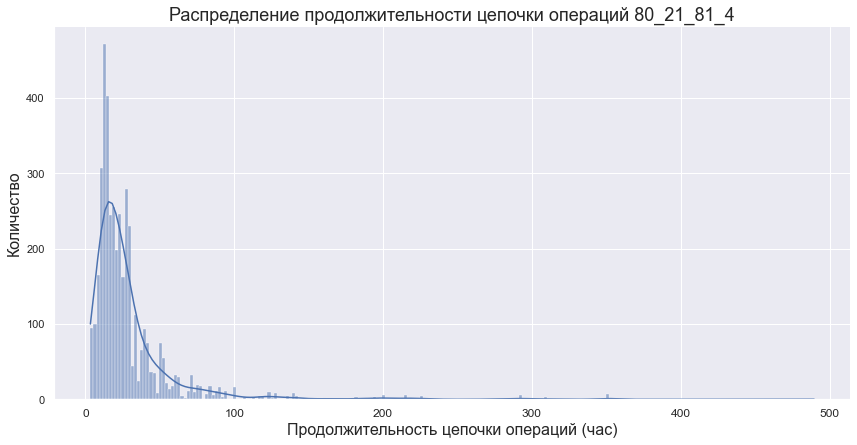

In [256]:
plot_distr('80_21_81_4')

c:\users\user\appdata\local\programs\python\python39\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


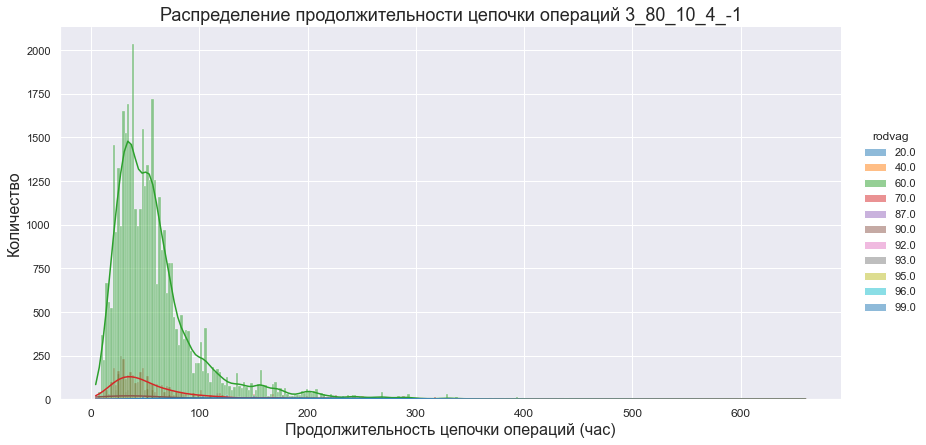

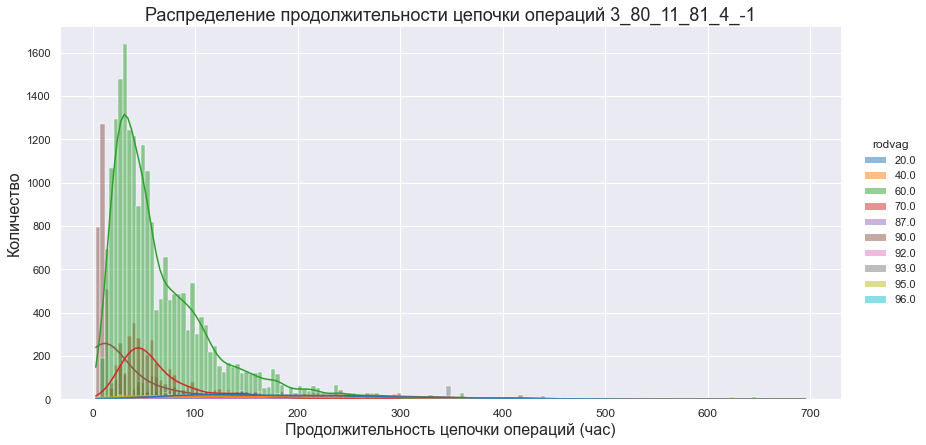

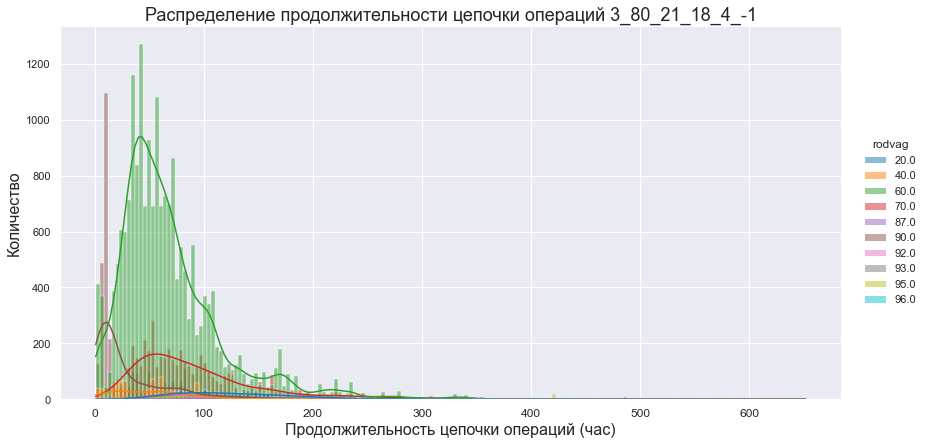

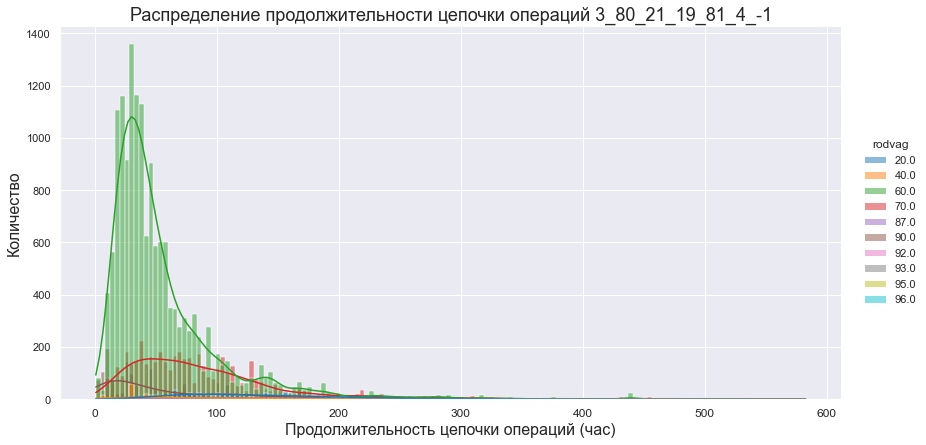

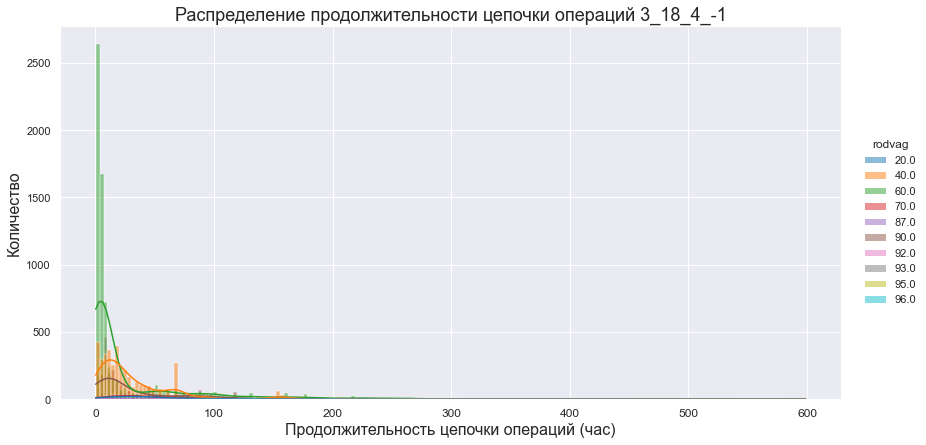

In [243]:
for chain in popular_chains.index[:5]:
    plot_distr(chain)